# Foreground Generation

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
import threading
import time
from collections import Counter
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Copy Data Files

In [ ]:

for ft in [
 'atf3_kla',
 'atf3_veh',
 'cebpa_kla',
 'cebpa_veh',
 'cjun_kla',
 'cjun_veh',
 'fos_kla',
 'fos_veh',
 'fra2_veh',
 'fra2_kla',
 'junb_kla',
 'junb_veh',
 'jund_kla',
 'jund_veh',
 'p65_kla',
 'p65_veh',
 'pu1_kla',
 'pu1_veh']:
    c57bl6_path = '/home/jtao/analysis/ap1_analysis/idrPeaks/c57bl6_' + ft + '_peaks.tsv'
    balbc_path = '/home/jtao/analysis/ap1_analysis/idrPeaks_strains/balbc_' + ft + '_peaks.tsv'
    ! cp $c57bl6_path ./peak_files/
    ! cp $balbc_path ./peak_files
    

### Resize Peak Files

In [ ]:
target_peak_size = 100

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./peak_files/'):
    current_peak_frame = pd.read_csv('./peak_files/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

### Create Group Summary Files

In [ ]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_peaks.tsv

In [ ]:
merged_frame = pd.read_csv('./merged_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_peaks_filtered_resized.tsv', sep='\t', index=False)

In [ ]:
! makeSummaryFile.py ./merged_peaks_filtered_resized.tsv ./group_summary.tsv ./resized_peak_files/*

### Retrieve Sequences Under Peaks

In [ ]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [ ]:
%%bash
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./merged_peaks_filtered_resized.tsv -output ./peak_sequences/C57BL6J_marge.fa
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains BALBCJ -file ./merged_peaks_filtered_resized.tsv -output ./peak_sequences/BALBCJ_marge.fa
# perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains NODSHILTJ -file ./merged_peaks_filtered_resized -output ./peak_sequences/NODSHILTJ_marge.fa


In [ ]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./merged_peaks_filtered_resized.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]

In [ ]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate]
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

### create a script to scan for motifs using FIMO



In [28]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/cobinding_motif_analysis/fimo_out/; fi
! rm -rf fimo_out/*
! rm -rf fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_'+ strain +'.sh','w')
        for m in sorted(os.listdir(motif_dir)):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
        #             '(sleep ' + str(15 * count) + 
                    '(sleep ' + str(0 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()

C57BL6J.fa


In [ ]:
%%bash
chmod a+x ./scanMotifs*
./scanMotifs_C57BL6J.sh
./scanMotifs_BALBCJ.sh
# ./scanMotifs_NODSHILTJ.sh

## Read in Scores

In [3]:
# read in peak data data
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,8,9,11,13,14,15,19,23,24,25,26,29,31,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


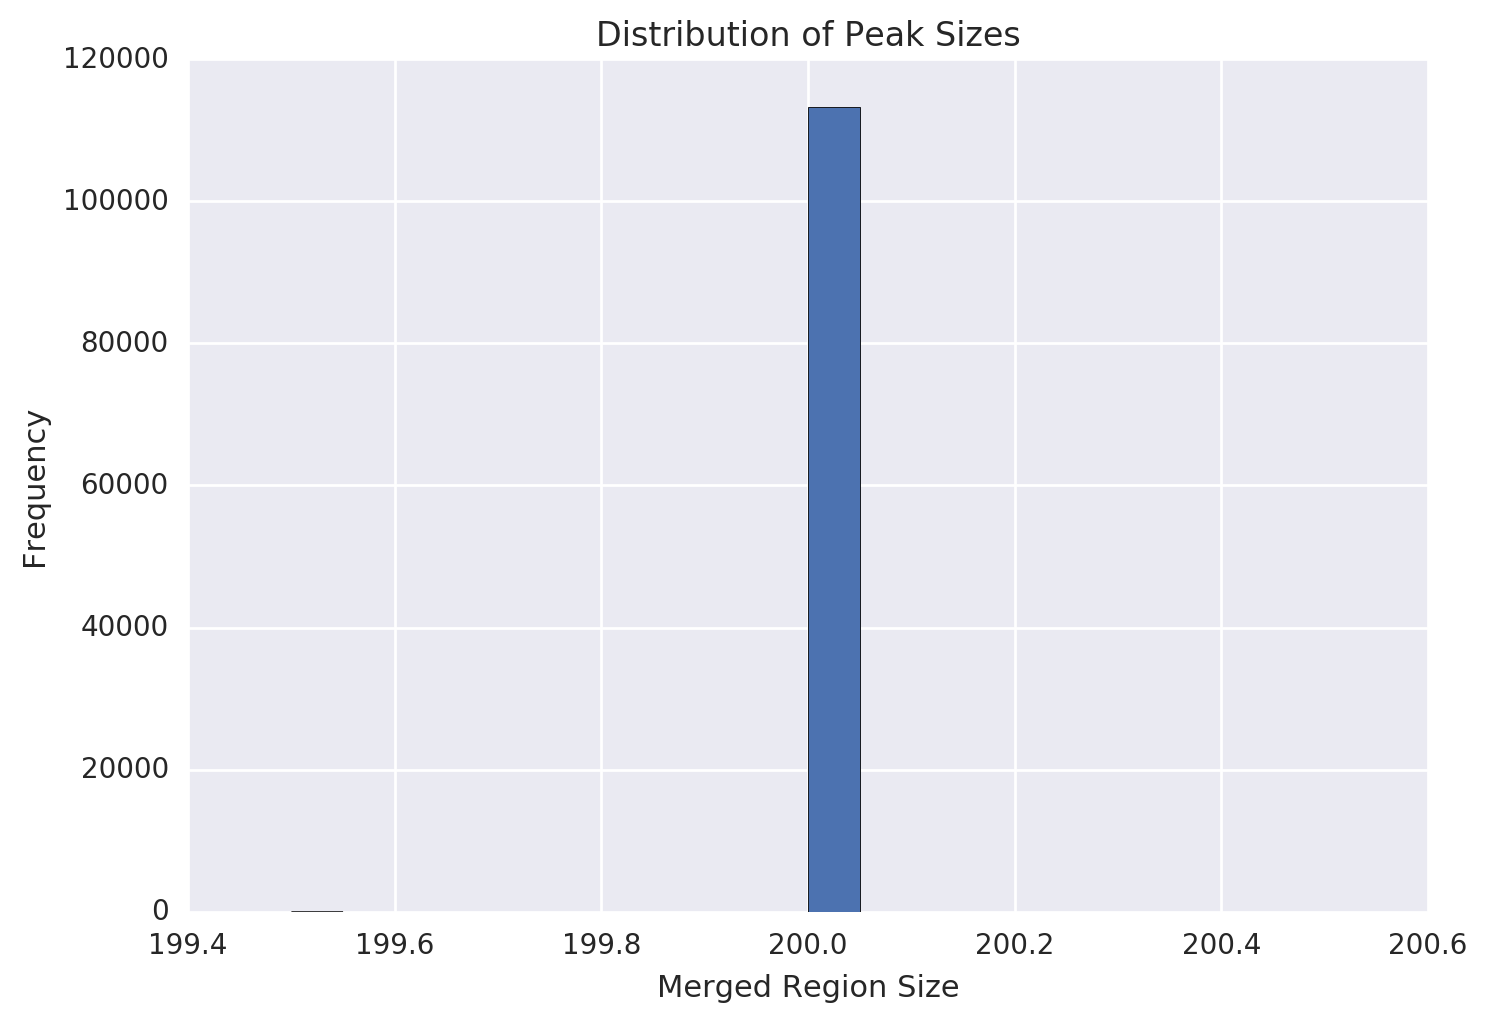

In [4]:
# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

### Read in Motif Scores

In [ ]:
def read_fimo_file(thread_lock, motif_results_path, 
                   all_peak_ids,
                   motif_score_dict,
                   motif_sequence_dict,
                   motif_strand_dict,
                   motif_start_dict,
                   motif_end_dict,
                   motif_count_dict,
                  ):
    
    # read in fimo result as data frame
    fimo_result_dict=pd.read_csv(motif_results_path, 
                                  skiprows=1,
                                  names=['motif_name', 
                                         'peak_id', 
                                         'start', 
                                         'stop', 
                                         'strand', 
                                         'score', 
                                         'pvalue', 
                                         'sequence'],
                                  sep='\t')
    motif_name = fimo_result_dict['motif_name'].values[0]
    print('reading', motif_name)
    
    id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}
    # drop all motif instances that has less than the maximum score
    sorted_fimo_result_dict = fimo_result_dict.sort_values(by='score', ascending=False)
    top_fimo_result_dict = sorted_fimo_result_dict.drop_duplicates(subset='peak_id')
    
    # convert data frame to a dictionary 
    unique_peak_ids = top_fimo_result_dict['peak_id'].values
    scores = top_fimo_result_dict['score'].values
    strands = top_fimo_result_dict['strand'].values
    sequences = top_fimo_result_dict['sequence'].values
    starts = top_fimo_result_dict['start'].values
    ends = top_fimo_result_dict['stop'].values
    
    for i in range(len(unique_peak_ids)):
        currentPeakID = unique_peak_ids[i]
        currentScore = float(scores[i])
        currentSequence = sequences[i]
        currentStrand = strands[i]
        currentStart = int(starts[i])
        currentEnd = int(ends[i])
        # bundle values
        
        if currentScore < 0.0:
            currentScore = 0.0
        
        newValues = (currentScore, 
                     currentSequence, 
                     currentStrand, 
                     currentStart, 
                     currentEnd, 
                     )
        id_values_dict[currentPeakID] = newValues
    
    # sort values according to all peak IDs
    sorted_values = [id_values_dict[x] if x in id_values_dict else (0,'','?',-1,-1) for x in  all_peak_ids]
    sorted_scores = [x[0] for x in sorted_values]
    sorted_sequences = [x[1] for x in sorted_values]
    sorted_strands = [x[2] for x in sorted_values]
    sorted_starts = [x[3] for x in sorted_values]
    sorted_ends = [x[4] for x in sorted_values]
    
    # count the number of motif instances
    peak_ids = fimo_result_dict['peak_id'].values
    id_count_dict = Counter(peak_ids)
    
    sorted_counts = [id_count_dict[x] if x in id_count_dict else 0 for x in all_peak_ids]
    
    while thread_lock.locked_lock():
        time.sleep(1)
    thread_lock.acquire()
        
    motif_score_dict[motif_name] = sorted_scores
    motif_sequence_dict[motif_name] = sorted_sequences
    motif_strand_dict[motif_name] = sorted_strands
    motif_start_dict[motif_name] = sorted_starts
    motif_end_dict[motif_name] = sorted_ends
    motif_count_dict[motif_name] = sorted_counts
    # release lock
    print('finished reading', motif_name )
    if thread_lock.locked_lock():
        thread_lock.release()
    
    return None

In [ ]:
start = time.time()
fimo_result_path = './fimo_results/'
for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        motif_score_dict = {}
        motif_sequence_dict ={}
        motif_strand_dict = {}
        motif_start_dict = {}
        motif_end_dict = {}
        motif_count_dict = {}
        thread_list = []
        all_peak_ids = summary_frame.index.values
        lock = threading.Lock()
        for m in sorted(os.listdir('./fimo_results')):
            try:
                current_thread = threading.Thread(target = read_fimo_file,
                                 args =(lock,
                                        fimo_result_path + '/' + m, 
                                        all_peak_ids,
                                        motif_score_dict,
                                        motif_sequence_dict,
                                        motif_strand_dict,
                                        motif_start_dict,
                                        motif_end_dict,
                                        motif_count_dict,
                                        ))
                thread_list.append(current_thread)
                current_thread.start()
            finally:
                if lock.locked_lock():
                    lock.release()
        for current_thread in thread_list:
            current_thread.join()
        
        # convert dictionaries to data frames
        motif_score_frame = pd.DataFrame(motif_score_dict , index = summary_frame['ID'].values)
        motif_sequence_frame = pd.DataFrame(motif_sequence_dict , index = summary_frame['ID'].values)
        motif_strand_frame = pd.DataFrame(motif_strand_dict , index = summary_frame['ID'].values)
        motif_start_frame = pd.DataFrame(motif_start_dict , index = summary_frame['ID'].values)
        motif_end_frame = pd.DataFrame(motif_end_dict , index = summary_frame['ID'].values)
        motif_count_frame = pd.DataFrame(motif_count_dict , index = summary_frame['ID'].values)

        for frame in [motif_score_frame, 
                      motif_sequence_frame, 
                      motif_strand_frame, 
                      motif_start_frame, 
                      motif_end_frame, 
                      motif_count_frame]:
            motif_cols = frame.columns.values
            frame['ID'] = summary_frame['ID'].values
            frame['Factors'] = summary_frame['Factors'].values
            frame['chr'] = summary_frame['chr'].values

        motif_score_frame.to_pickle('motif_score_frame_'+  strain + '.pickle2')

        motif_sequence_frame.to_pickle('motif_sequence_frame_'+  strain + '.pickle2')

        motif_strand_frame.to_pickle('motif_strand_frame_'+  strain + '.pickle2')

        motif_start_frame.to_pickle('motif_start_frame_'+  strain + '.pickle2')

        motif_end_frame.to_pickle('motif_end_frame_'+  strain + '.pickle2')

        motif_count_frame.to_pickle('motif_count_frame_'+  strain + '.pickle2')
        
end = time.time()
print('total time', end - start)






C57BL6J.fa
reading dmrt3
reading cux
reading e2f2
reading arid3a
reading gmeb2
reading dmbx1
reading alx1_alx4_arx
reading crem
reading arid5a
readingreading gsc
 hnf1
reading atf7_batf3_creb5
reading ebox
reading e2f1
reading dux
reading ap-1
reading creb3-l1
reading bhlhe23
reading cenpb


In [ ]:
motif_count_frame